# Decision Trees

A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. It has a hierarchical, tree structure, which consists of a root node, branches, internal nodes and leaf nodes.

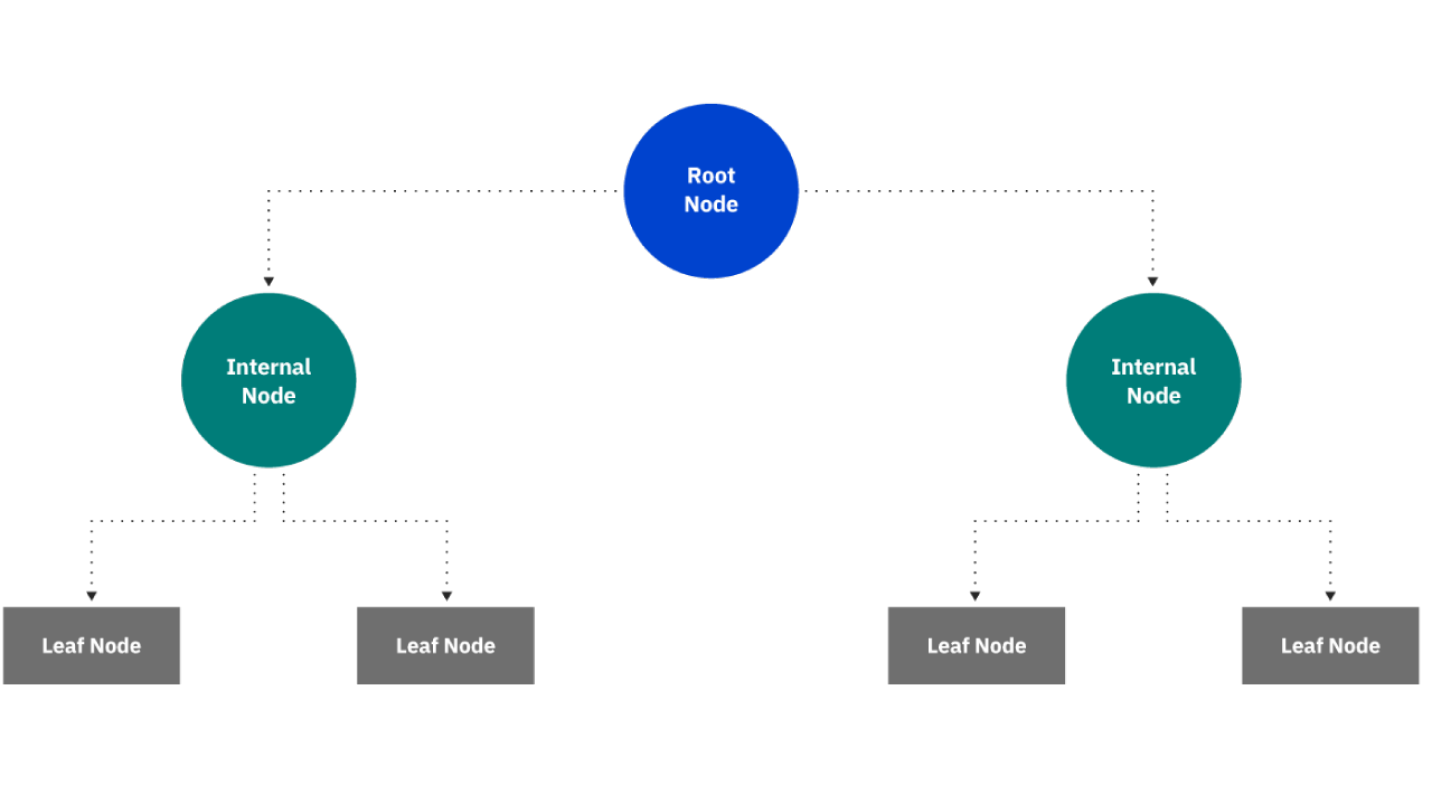
                                 

Basic Structure of Decision Tree

# Example
As an example, let’s imagine that you were trying to assess whether or not you should go surf, you may use the following decision rules to make a choice:

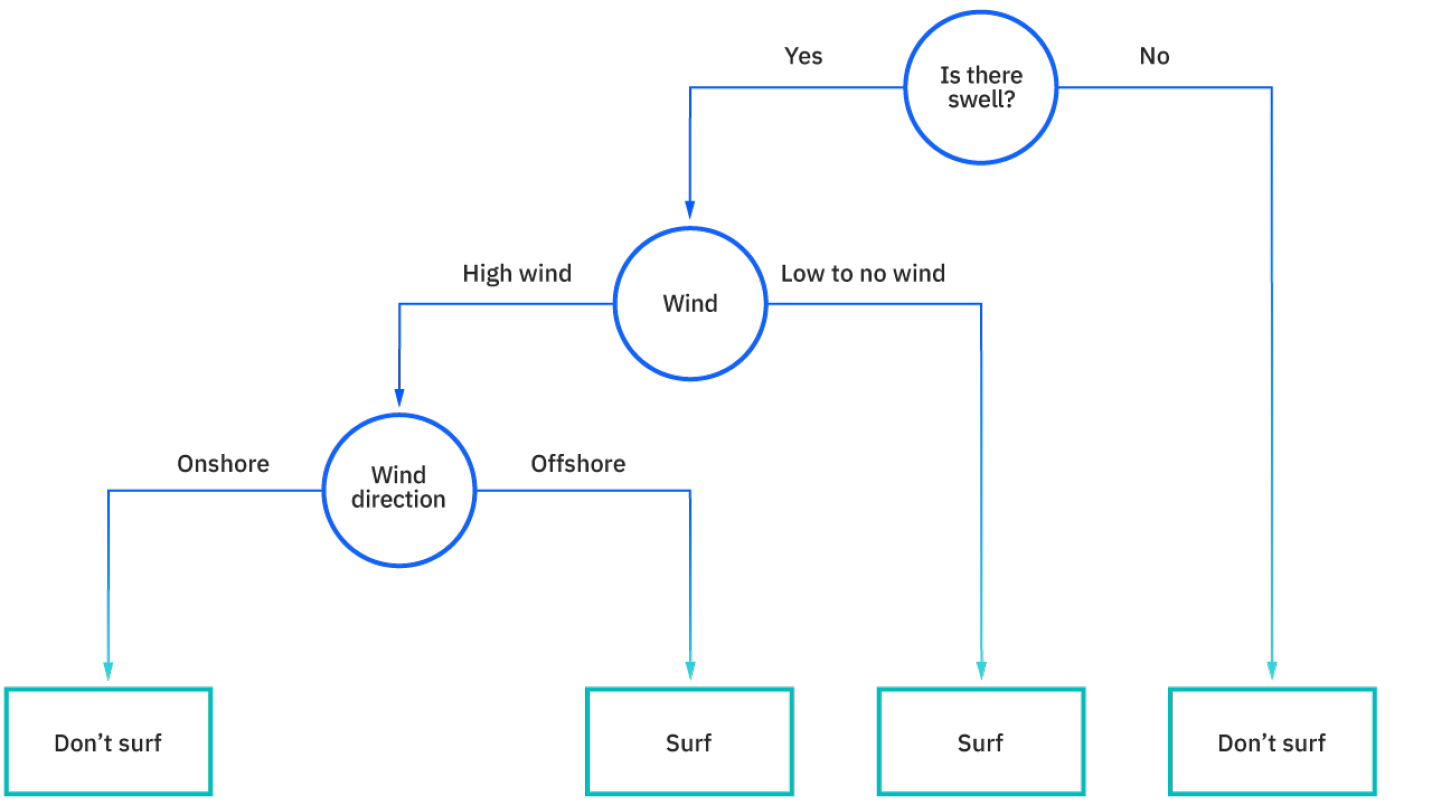

For classification problem there are two main indicators: "gini impurity" and "information entropy".
   In this notebook <b>"Gini impurity"</b> will be used.</i></font>
   
# Gini Impurity

<p style="text-align: center;"><font size="4"><b><I>"A measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.”</I></b><font></p>

<p style="text-align: center;"><font size="8"><b>G=1-$\sum_{i=1}^{N} Pk^2$</b></font></p>
<br><br>

    n is the number of samples and Pk² is the proportion of observations of class k

In [27]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

data = load_iris()
X, y, column_names = data['data'], data['target'], data['feature_names']
X = pd.DataFrame(X, columns = column_names)
X['target'] = y

In [28]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [29]:
X, y = X.drop(columns = 'target'), X['target']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 44)

In [30]:
class Node:
    def __init__(self):
        
        # links to the left and right child nodes
        self.right = None
        self.left = None
        
        # derived from splitting criteria
        self.column = None
        self.threshold = None
        
        # probability for object inside the Node to belong for each of the given classes
        self.probas = None
        # depth of the given node
        self.depth = None
        
        # if it is the root Node or not
        self.is_terminal = False

In [31]:
class DecisionTreeClassifier:
    def __init__(self, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2):
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        
        # Decision tree itself
        self.Tree = None
    # probas means probability
    
    def nodeProbas(self, y):
        '''
        Calculates probability of class in a given node
        '''
        probas = []
        
        # for each unique label calculate the probability for it
        for one_class in self.classes:
            proba = y[y == one_class].shape[0] / y.shape[0]
            probas.append(proba)
        return np.asarray(probas)
        
    

    def gini(self, probas):
        '''
        Calculates gini criterion
        '''
        return 1 - np.sum(probas**2)
    
    def calcImpurity(self, y):
        '''
        Wrapper for the impurity calculation. Calculates probas first and then passses them
        to the Gini criterion
        '''
        return self.gini(self.nodeProbas(y))
    
    def calcBestSplit(self, X, y):
        '''
        Calculates the best possible split for the concrete node of the tree
        '''
        
        bestSplitCol = None
        bestThresh = None
        bestInfoGain = -999
        
        impurityBefore = self.calcImpurity(y)
        
        # for each column in X
        for col in range(X.shape[1]):
            x_col = X[:, col]
            
            # for each value in the column
            for x_i in x_col:
                threshold = x_i
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]
                
                if y_right.shape[0] == 0 or y_left.shape[0] == 0:
                    continue
                    
                # calculate impurity for the right and left nodes
                impurityRight = self.calcImpurity(y_right)
                impurityLeft = self.calcImpurity(y_left)
                
                # calculate information gain
                infoGain = impurityBefore
                infoGain -= (impurityLeft * y_left.shape[0] / y.shape[0]) + (impurityRight * y_right.shape[0] / y.shape[0])
                
                # is this infoGain better then all other?
                if infoGain > bestInfoGain:
                    bestSplitCol = col
                    bestThresh = threshold
                    bestInfoGain = infoGain
                    
        
        # if we still didn't find the split
        if bestInfoGain == -999:
            return None, None, None, None, None, None
        
        # making the best split
        
        x_col = X[:, bestSplitCol]
        x_left, x_right = X[x_col <= bestThresh, :], X[x_col > bestThresh, :]
        y_left, y_right = y[x_col <= bestThresh], y[x_col > bestThresh]
        
        return bestSplitCol, bestThresh, x_left, y_left, x_right, y_right
    
    def buildDT(self, X, y, node):
        '''
        Recursively builds decision tree from the top to bottom
        '''
        
         # checking for the terminal conditions
        
        if node.depth >= self.max_depth:
            node.is_terminal = True
            return
        
        if X.shape[0] < self.min_samples_split:
            node.is_terminal = True
            return
        
        if np.unique(y).shape[0] == 1:
            node.is_terminal = True
            return
        
        # calculating current split
        splitCol, thresh, x_left, y_left, x_right, y_right = self.calcBestSplit(X, y)
        
        if splitCol is None:
            node.is_terminal = True
            
        if x_left.shape[0] < self.min_samples_leaf or x_right.shape[0] < self.min_samples_leaf:
            node.is_terminal = True
            return
        
        node.column = splitCol
        node.threshold = thresh
        
        # creating left and right child nodes
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.nodeProbas(y_left)
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.nodeProbas(y_right)
        
        # splitting recursevely
        self.buildDT(x_right, y_right, node.right)
        self.buildDT(x_left, y_left, node.left)
    
    def fit(self, X, y):
        '''
        Standard fit function to run all the model training
        '''
        
         
        if type(X) == pd.DataFrame:
            X = np.asarray(X)
        
        self.classes = np.unique(y)
        # root node creation
        self.Tree = Node()
        self.Tree.depth = 1
        self.Tree.probas = self.nodeProbas(y)
        
        self.buildDT(X, y, self.Tree)
    
    def predictSample(self, x, node):
        '''
        Passes one object through decision tree and return the probability of it to belong to each class
        '''
       
        # if we have reached the terminal node of the tree
        if node.is_terminal:
            return node.probas
        
        if x[node.column] > node.threshold:
            probas = self.predictSample(x, node.right)
        else:
            probas = self.predictSample(x, node.left)
            
        return probas
    
    def predict(self, X):
        '''
        Returns the labels for each X
        '''
        
        if type(X) == pd.DataFrame:
            X = np.asarray(X)
            
        predictions = []
        for x in X:
            pred = np.argmax(self.predictSample(x, self.Tree))
            predictions.append(pred)
        
        return np.asarray(predictions)

In [32]:
%%time

#running our model on the data set

model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=2, min_samples_split=2)
model.fit(X_train, y_train)

CPU times: total: 1.14 s
Wall time: 1.15 s


In [33]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_val)
print(f'Accuracy for self built model {accuracy_score(y_val, y_pred)}')

Accuracy for self built model 0.9473684210526315


In [34]:
%%time 

from sklearn.tree import DecisionTreeClassifier as DTC
model = DTC(max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Accuracy for sklearn Decision Tree {accuracy_score(y_val, y_pred)}')

Accuracy for sklearn Decision Tree 0.9736842105263158
CPU times: total: 0 ns
Wall time: 7.98 ms
